In [1]:
import pandas as pd
import os, json
from ast import literal_eval
import seaborn as sns
sns.set_context(font_scale=1.1)
from matplotlib import pyplot as plt
from datetime import datetime, timedelta

# Processing text files into one Json File for Wise and PayPal.

In [3]:
all_details = []
for paypal_file in os.listdir("./data/Paypal"):
    data = [literal_eval(i.strip()) for i in open(f'./data/Paypal/{paypal_file}').readlines()]
    all_details.extend(data)
df = pd.DataFrame(all_details)
df.head(3)

,platform,id,stars,title,message,review_date,review_time,CompanyReply,CompanyReplyDate,CompanyReplyTime
0,Paypal,6301dfe77e1f0c3dc2e54151,1,"Bad for business account, they don’t care abou...",Bad service for sellers\nEverytime a payment c...,2022-08-21,09:33:59,None,None,None
1,Paypal,6301a481142fce1f450012a9,5,PayPal is the best online payment system!,"As a freelance blogger, PayPal is the best onl...",2022-08-21,09:45:29,None,None,None
2,Paypal,63011993142fce1f45ffdc29,1,Very disappointed with PayPal,"Very disappointed with PayPal, that’s all I ca...",2022-08-20,19:27:47,None,None,None


In [4]:
df["review_datetime"] = df["review_date"] +"T"+ df["review_time"]
df["review_datetime"]  = pd.to_datetime(df["review_datetime"])
df["company_reply_datetime"] = df["CompanyReplyDate"] + "T" + df["CompanyReplyTime"]
df["company_reply_datetime"] = pd.to_datetime(df["company_reply_datetime"])

df["time_taken_to_reply"] = ((df["company_reply_datetime"] - df["review_datetime"]).dt.total_seconds() / (60 * 60 * 24)).round()
# Replace NaN values with a placeholder (e.g., -1)
df["time_taken_to_reply"] = df["time_taken_to_reply"].fillna(-999).astype(int)
df = df[df["review_datetime"]>="2022-04-01"]

# Find the maximum date in the DataFrame
max_date = df['review_datetime'].max()

# Calculate the date 1 year ago from the maximum date
one_year_ago = max_date - timedelta(days=365)


df['Month-Year'] = df['review_datetime'].dt.to_period('m')
df['Month-Year'] = df['Month-Year'].dt.to_timestamp()

df.head(2)

,platform,id,stars,title,message,review_date,review_time,CompanyReply,CompanyReplyDate,CompanyReplyTime,review_datetime,company_reply_datetime,time_taken_to_reply,Month-Year
0,Paypal,6301dfe77e1f0c3dc2e54151,1,"Bad for business account, they don’t care abou...",Bad service for sellers\nEverytime a payment c...,2022-08-21,09:33:59,None,None,None,2022-08-21 09:33:59,NaT,-999,2022-08-01
1,Paypal,6301a481142fce1f450012a9,5,PayPal is the best online payment system!,"As a freelance blogger, PayPal is the best onl...",2022-08-21,09:45:29,None,None,None,2022-08-21 09:45:29,NaT,-999,2022-08-01


## Reviews over Time

<Axes: xlabel='Month-Year', ylabel='Count'>

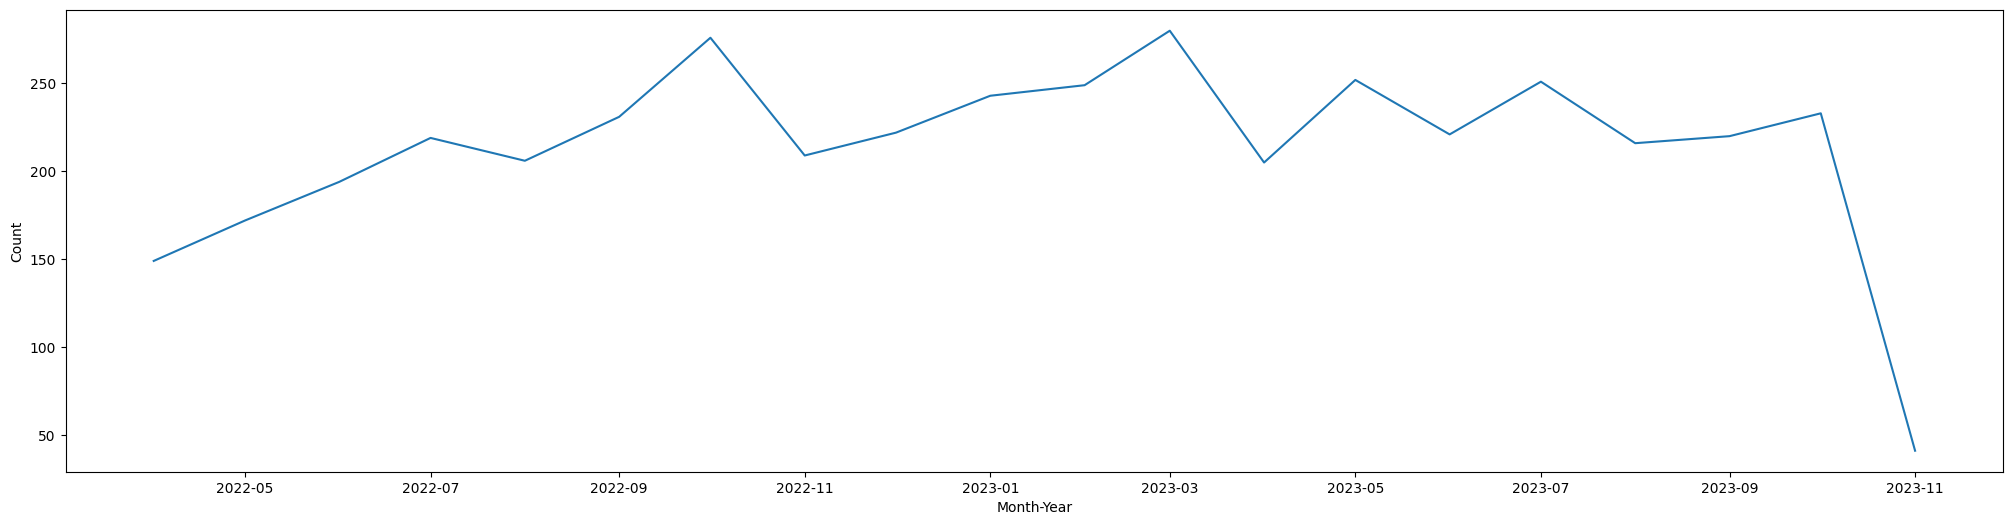

In [5]:
# df['Month-Year'] = df['review_datetime'].dt.strftime('%y-%m')
reviews_over_time = df.groupby('Month-Year').size().reset_index(name='Count')
plt.figure(figsize=(25, 6))
sns.lineplot(data= reviews_over_time, x="Month-Year", y="Count")

## Ratings Across Time

In [6]:
ratings_over_time = df.groupby('Month-Year').agg({'stars': 'mean'}).reset_index()
ratings_over_time['stars'] = ratings_over_time['stars'].round(1)

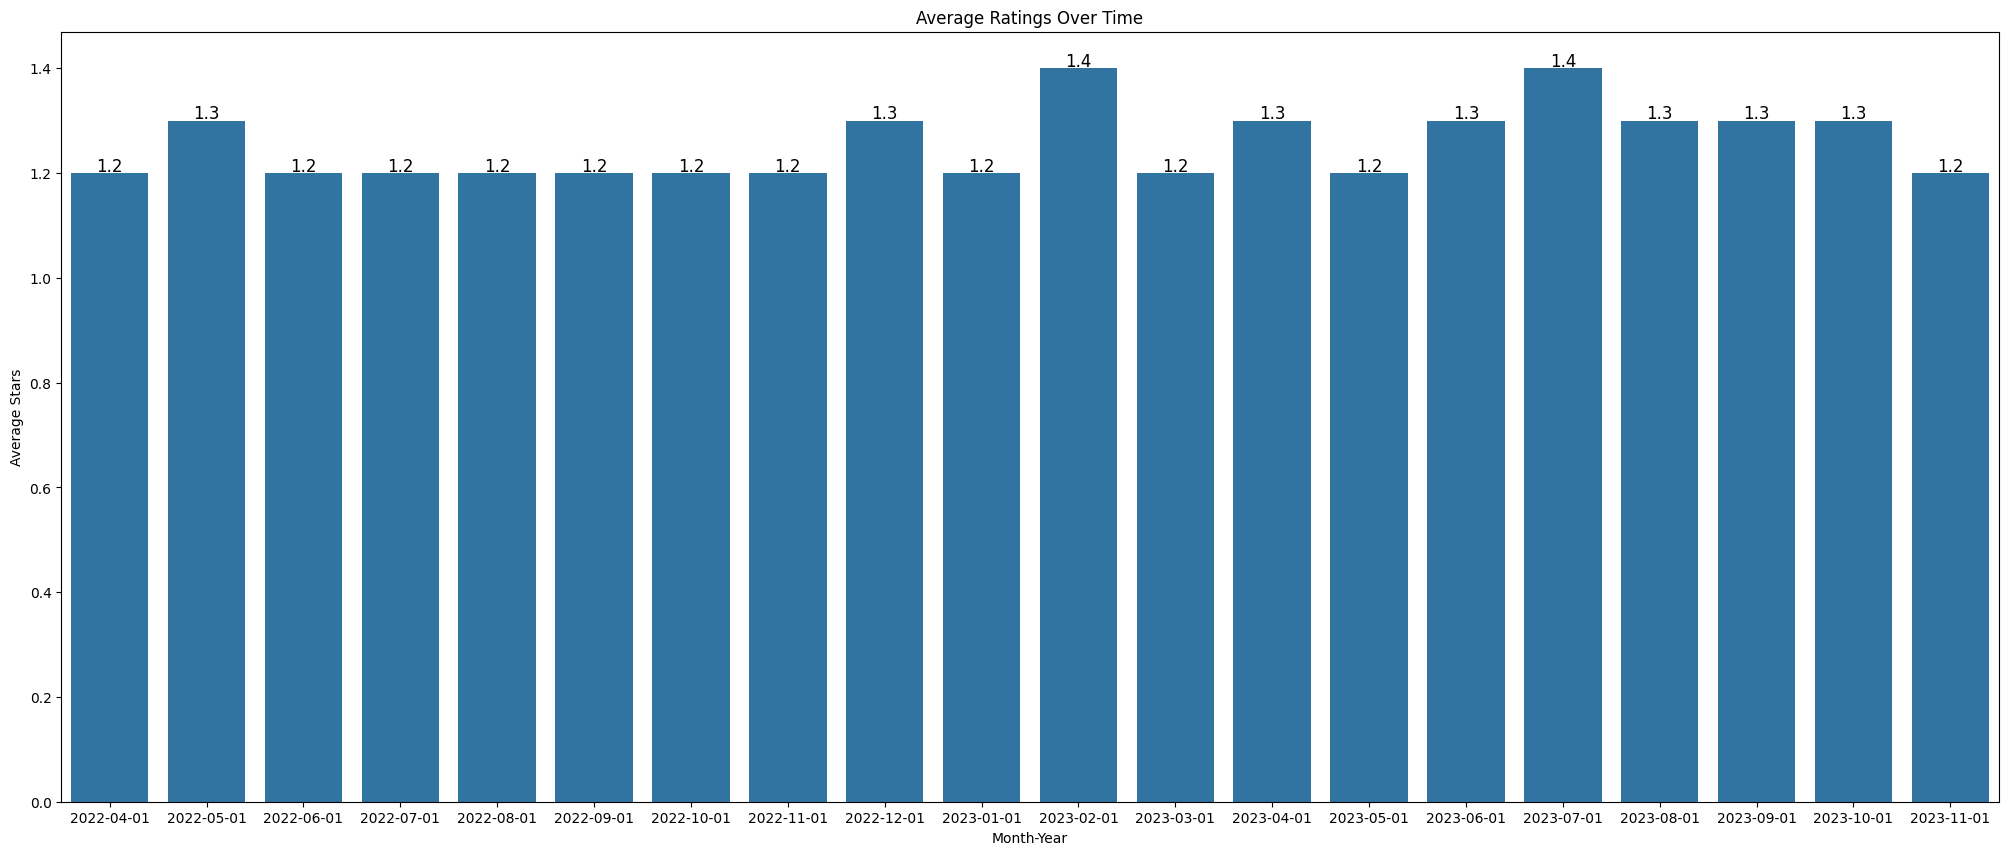

In [7]:
plt.figure(figsize=(25, 10))
# sns.barplot(data= ratings_over_time, x="Month-Year", y="stars")

ax = sns.barplot(data=ratings_over_time, x="Month-Year", y="stars")

# Add labels within the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=12, color='black', xytext=(0, 5), textcoords='offset points')

# Add labels
plt.title('Average Ratings Over Time')
plt.xlabel('Month-Year')
plt.ylabel('Average Stars')

plt.show()


In [8]:
ratings_overtime_2 = df.groupby(['Month-Year', 'stars']).size().reset_index(name='Count')

<Axes: xlabel='Month-Year', ylabel='Count'>

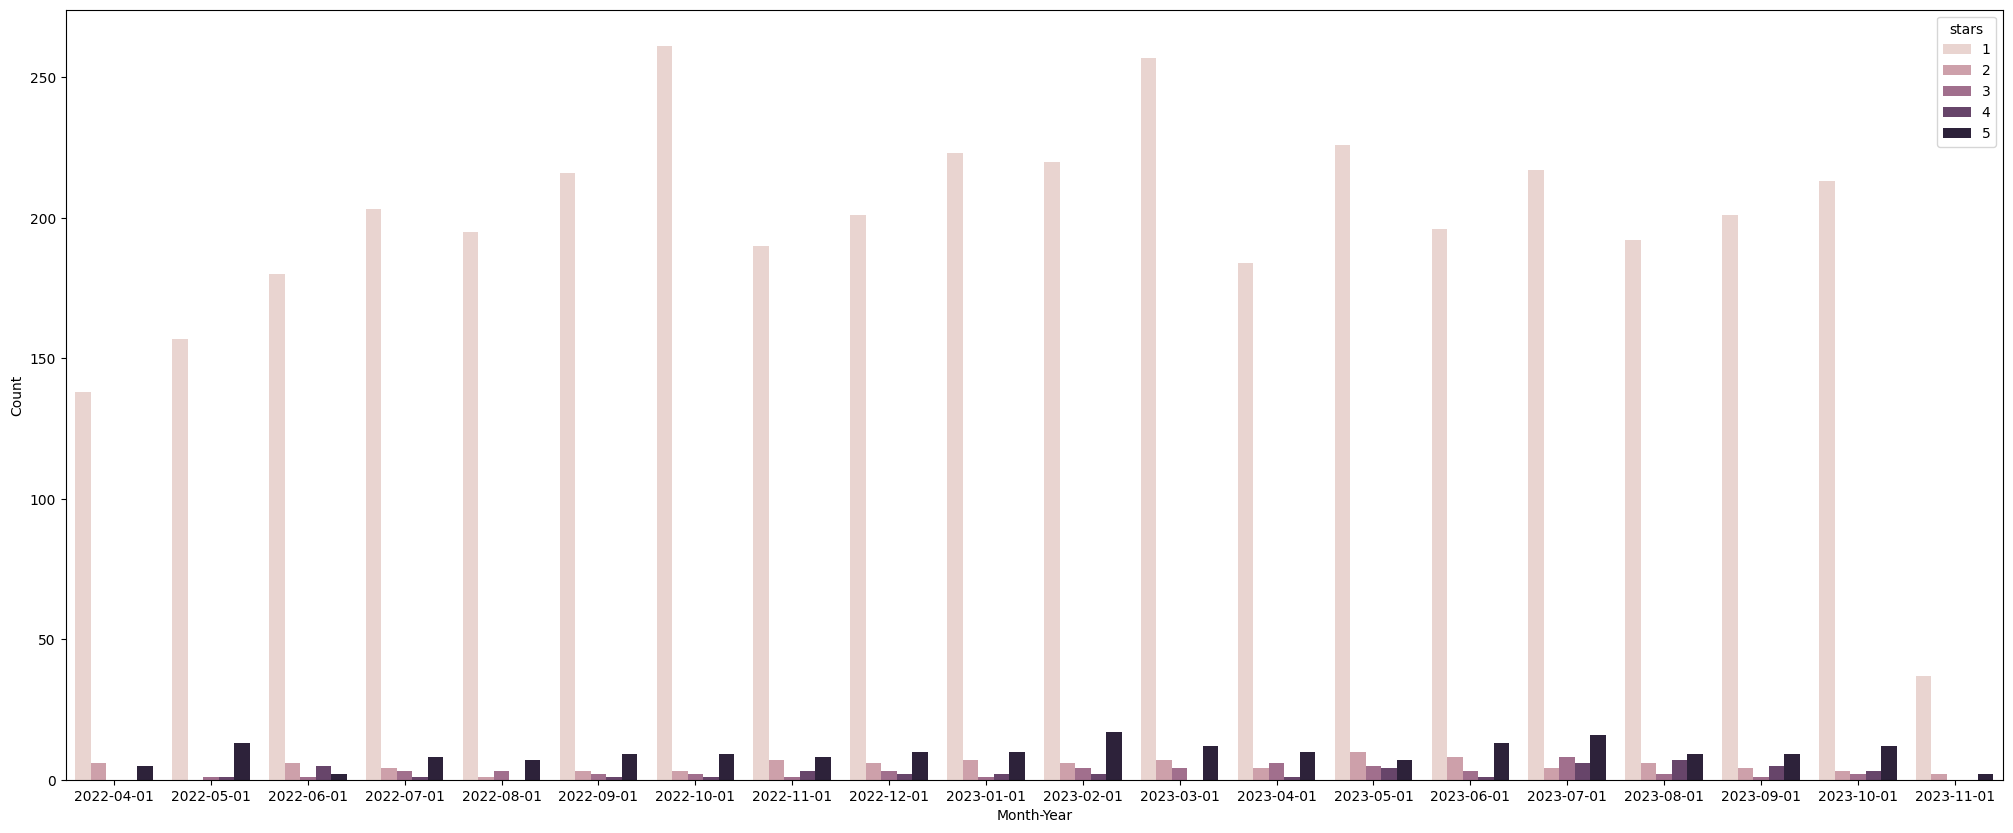

In [9]:
plt.figure(figsize=(25, 10))
sns.barplot(data=ratings_overtime_2, x="Month-Year", y="Count", hue="stars")

In [10]:
ratings_overtime_2 = df.groupby(['Month-Year', 'stars']).size().reset_index(name='Count')

# Pivot the table to make it easier to calculate percentages
pivoted = ratings_overtime_2.pivot(index='Month-Year', columns='stars', values='Count')

# Calculate the percentages
pivoted['1-Star %'] = ((pivoted[1] / pivoted.sum(axis=1)) * 100).round(1)
pivoted['5-Star %'] = ((pivoted[5] / pivoted.sum(axis=1)) * 100).round(1)
pivoted["Cumulative 1 and 5"] = pivoted['1-Star %'] + pivoted['5-Star %']

# Reset the index
pivoted.reset_index(inplace=True)

In [11]:
pivoted

stars,Month-Year,1,2,3,4,5,1-Star %,5-Star %,Cumulative 1 and 5
0,2022-04-01,138.0,6.0,NaN,NaN,5.0,92.6,2.1,94.7
1,2022-05-01,157.0,NaN,1.0,1.0,13.0,91.3,4.9,96.2
2,2022-06-01,180.0,6.0,1.0,5.0,2.0,92.8,0.7,93.5
3,2022-07-01,203.0,4.0,3.0,1.0,8.0,92.7,2.6,95.3
4,2022-08-01,195.0,1.0,3.0,NaN,7.0,94.7,2.3,97.0
5,2022-09-01,216.0,3.0,2.0,1.0,9.0,93.5,2.8,96.3
6,2022-10-01,261.0,3.0,2.0,1.0,9.0,94.6,2.4,97.0
7,2022-11-01,190.0,7.0,1.0,3.0,8.0,90.9,2.7,93.6
8,2022-12-01,201.0,6.0,3.0,2.0,10.0,90.5,3.2,93.7
9,2023-01-01,223.0,7.0,1.0,2.0,10.0,91.8,3.0,94.8


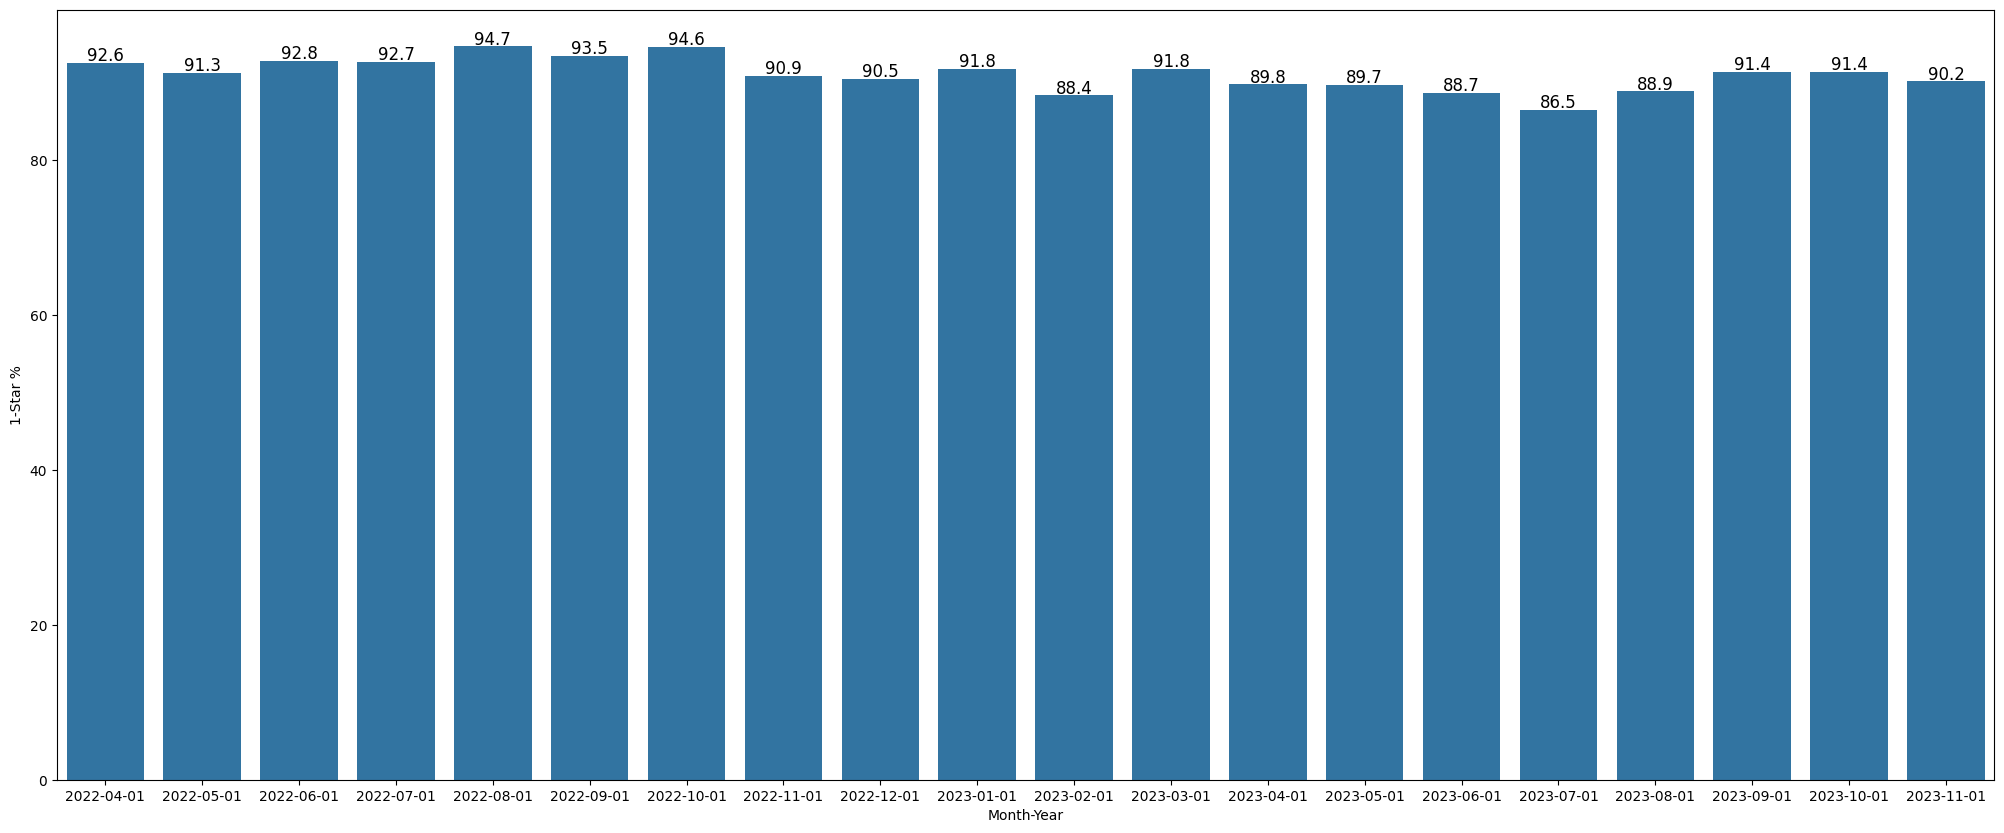

In [12]:
plt.figure(figsize=(25, 10))
ax = sns.barplot(data=pivoted, x="Month-Year", y="1-Star %")
for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=12, color='black', xytext=(0, 5), textcoords='offset points')


In [13]:
reply_rate = df.groupby('Month-Year')['CompanyReply'].apply(lambda x: (1-(x.isna().sum() / len(x))) * 100).reset_index(name='Reply Rate')

print(reply_rate)

   Month-Year  Reply Rate
0  2022-04-01         0.0
1  2022-05-01         0.0
2  2022-06-01         0.0
3  2022-07-01         0.0
4  2022-08-01         0.0
5  2022-09-01         0.0
6  2022-10-01         0.0
7  2022-11-01         0.0
8  2022-12-01         0.0
9  2023-01-01         0.0
10 2023-02-01         0.0
11 2023-03-01         0.0
12 2023-04-01         0.0
13 2023-05-01         0.0
14 2023-06-01         0.0
15 2023-07-01         0.0
16 2023-08-01         0.0
17 2023-09-01         0.0
18 2023-10-01         0.0
19 2023-11-01         0.0


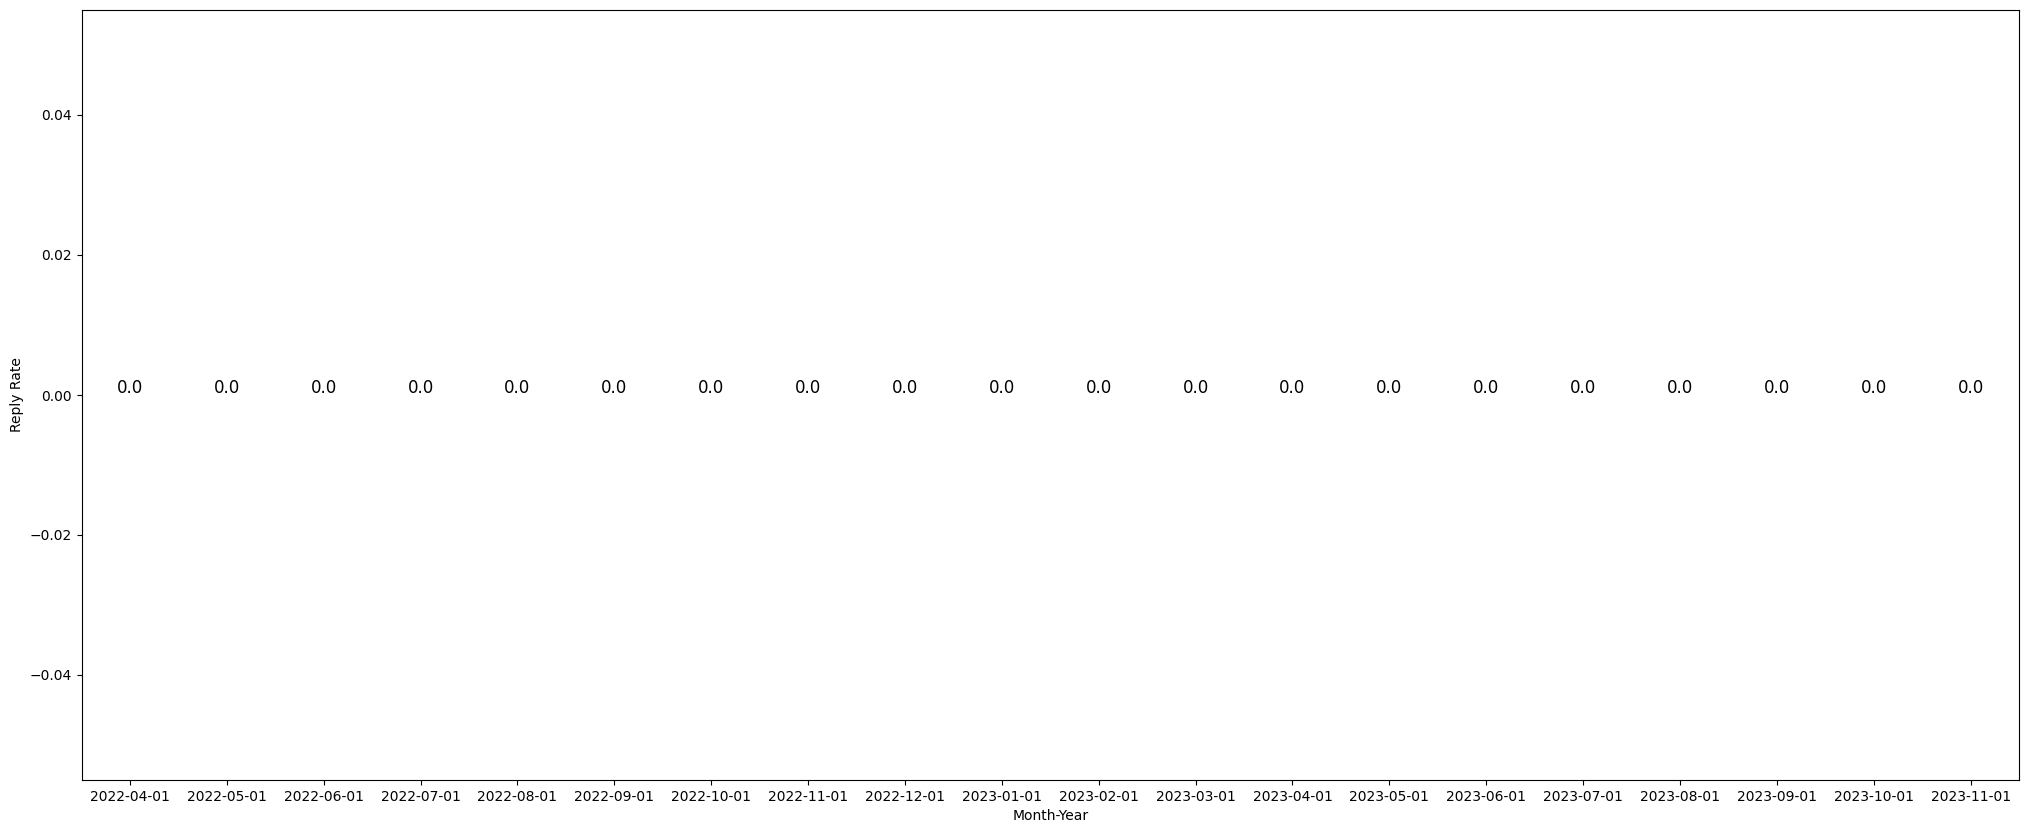

In [15]:
plt.figure(figsize=(25, 10))
ax = sns.barplot(data=reply_rate, x="Month-Year", y="Reply Rate")
for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=12, color='black', xytext=(0, 5), textcoords='offset points')


In [16]:
df_low_ratings = df[df["stars"]<3]
reply_rate_for_low_ratings = df_low_ratings.groupby('Month-Year')['CompanyReply'].apply(lambda x: (1-(x.isna().sum() / len(x))) * 100).reset_index(name='Reply Rate')

print(reply_rate_for_low_ratings)

   Month-Year  Reply Rate
0  2022-04-01         0.0
1  2022-05-01         0.0
2  2022-06-01         0.0
3  2022-07-01         0.0
4  2022-08-01         0.0
5  2022-09-01         0.0
6  2022-10-01         0.0
7  2022-11-01         0.0
8  2022-12-01         0.0
9  2023-01-01         0.0
10 2023-02-01         0.0
11 2023-03-01         0.0
12 2023-04-01         0.0
13 2023-05-01         0.0
14 2023-06-01         0.0
15 2023-07-01         0.0
16 2023-08-01         0.0
17 2023-09-01         0.0
18 2023-10-01         0.0
19 2023-11-01         0.0


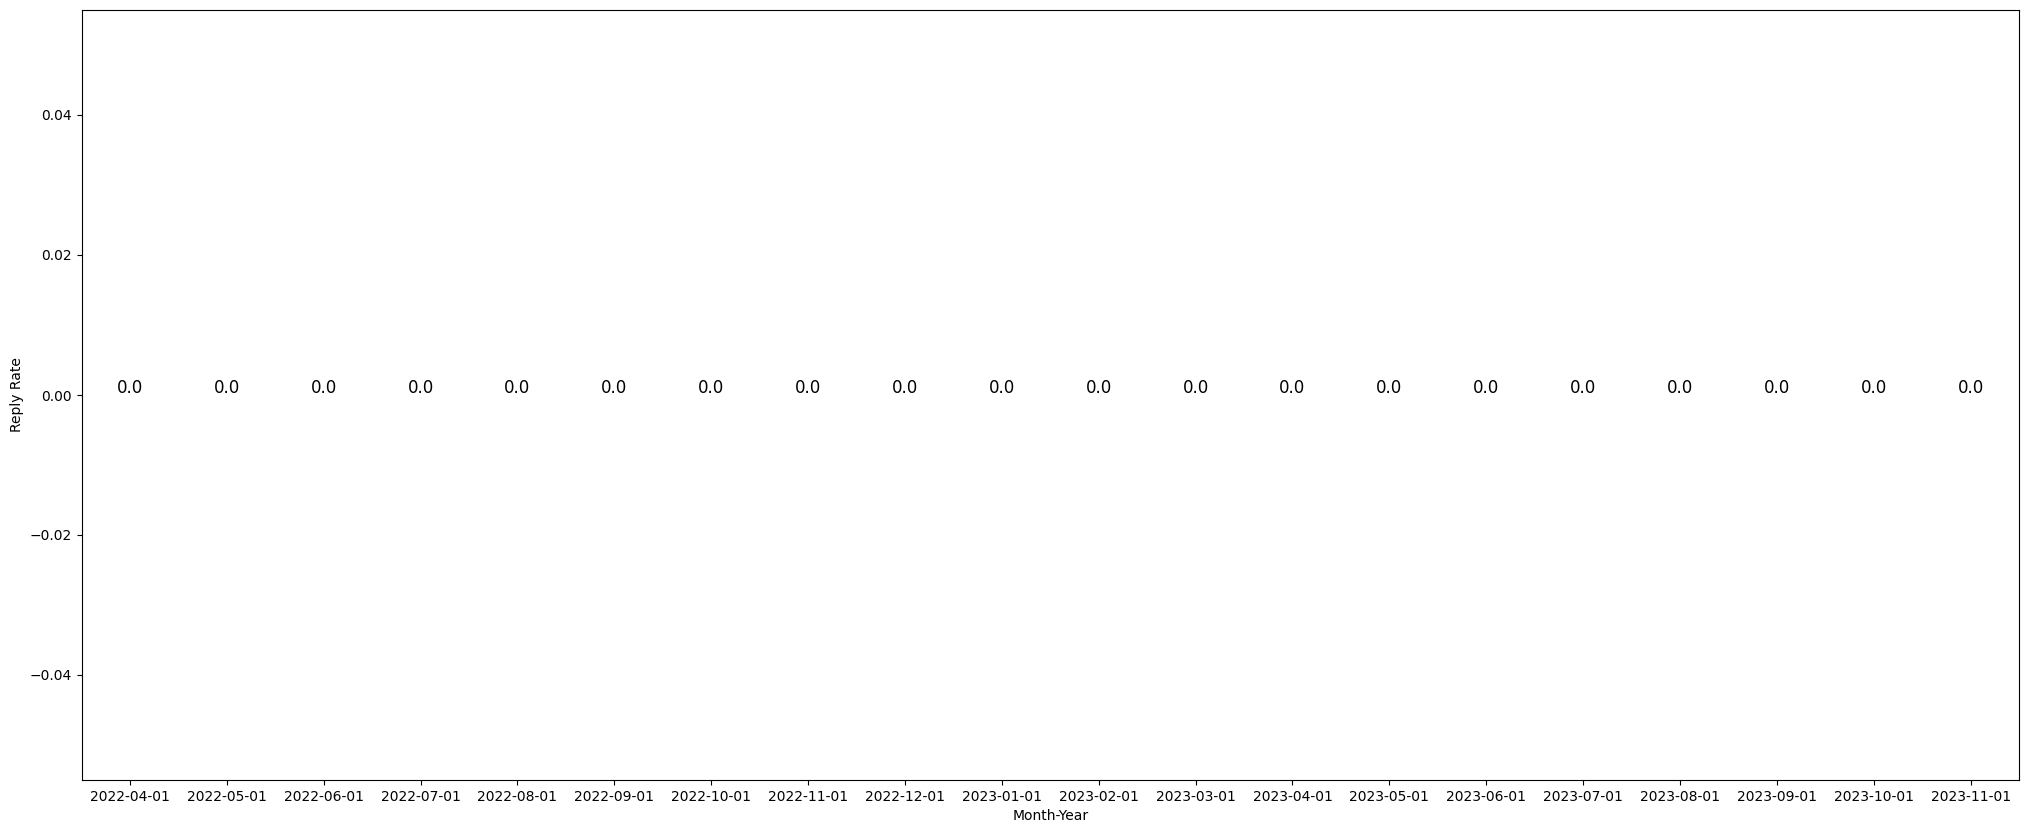

In [17]:
plt.figure(figsize=(25, 10))
ax = sns.barplot(data=reply_rate_for_low_ratings, x="Month-Year", y="Reply Rate")
for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=12, color='black', xytext=(0, 5), textcoords='offset points')


In [18]:
df_high_ratings = df[df["stars"]>3]
reply_rate_for_high_ratings = df_high_ratings.groupby('Month-Year')['CompanyReply'].apply(lambda x: (1-(x.isna().sum() / len(x))) * 100).reset_index(name='Reply Rate')

print(reply_rate_for_high_ratings)

   Month-Year  Reply Rate
0  2022-04-01         0.0
1  2022-05-01         0.0
2  2022-06-01         0.0
3  2022-07-01         0.0
4  2022-08-01         0.0
5  2022-09-01         0.0
6  2022-10-01         0.0
7  2022-11-01         0.0
8  2022-12-01         0.0
9  2023-01-01         0.0
10 2023-02-01         0.0
11 2023-03-01         0.0
12 2023-04-01         0.0
13 2023-05-01         0.0
14 2023-06-01         0.0
15 2023-07-01         0.0
16 2023-08-01         0.0
17 2023-09-01         0.0
18 2023-10-01         0.0
19 2023-11-01         0.0


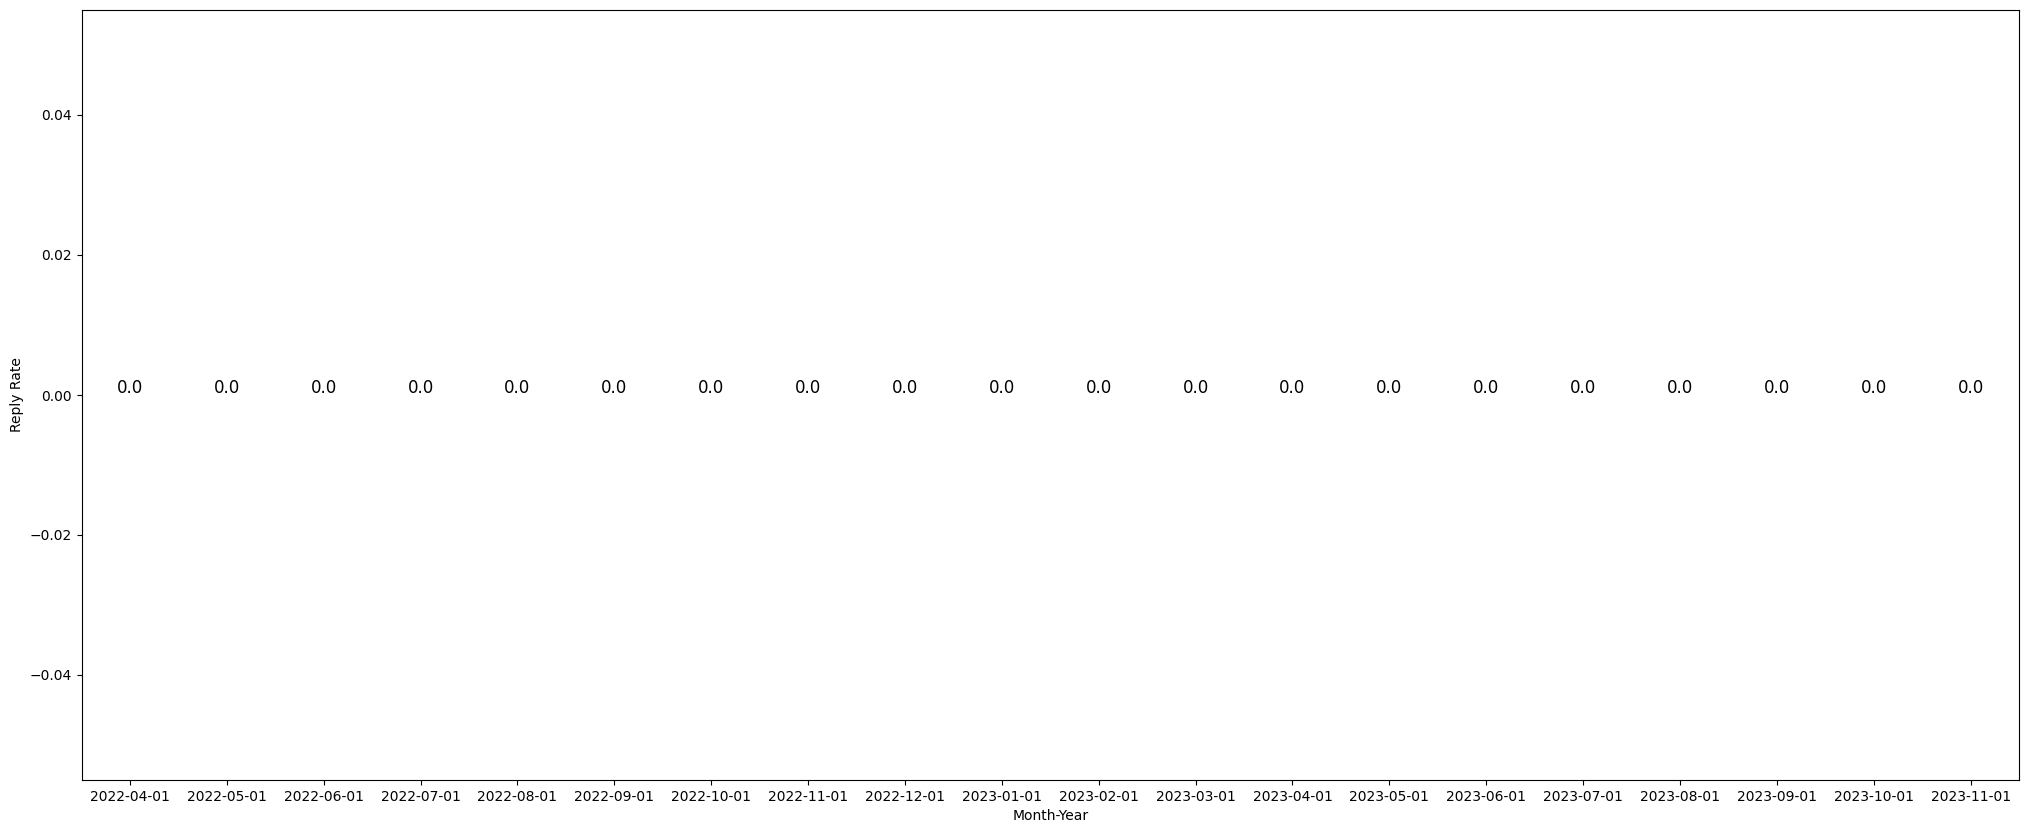

In [19]:
plt.figure(figsize=(25, 10))
ax = sns.barplot(data=reply_rate_for_high_ratings, x="Month-Year", y="Reply Rate")
for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=12, color='black', xytext=(0, 5), textcoords='offset points')


In [20]:
replied = df[(~df["company_reply_datetime"].isna()) & (df["time_taken_to_reply"]>=0)]

In [21]:
replies_over_time = replied.groupby('Month-Year').agg({'time_taken_to_reply': 'mean'}).reset_index()
replies_over_time['time_taken_to_reply'] = ratings_over_time['stars'].round(1)

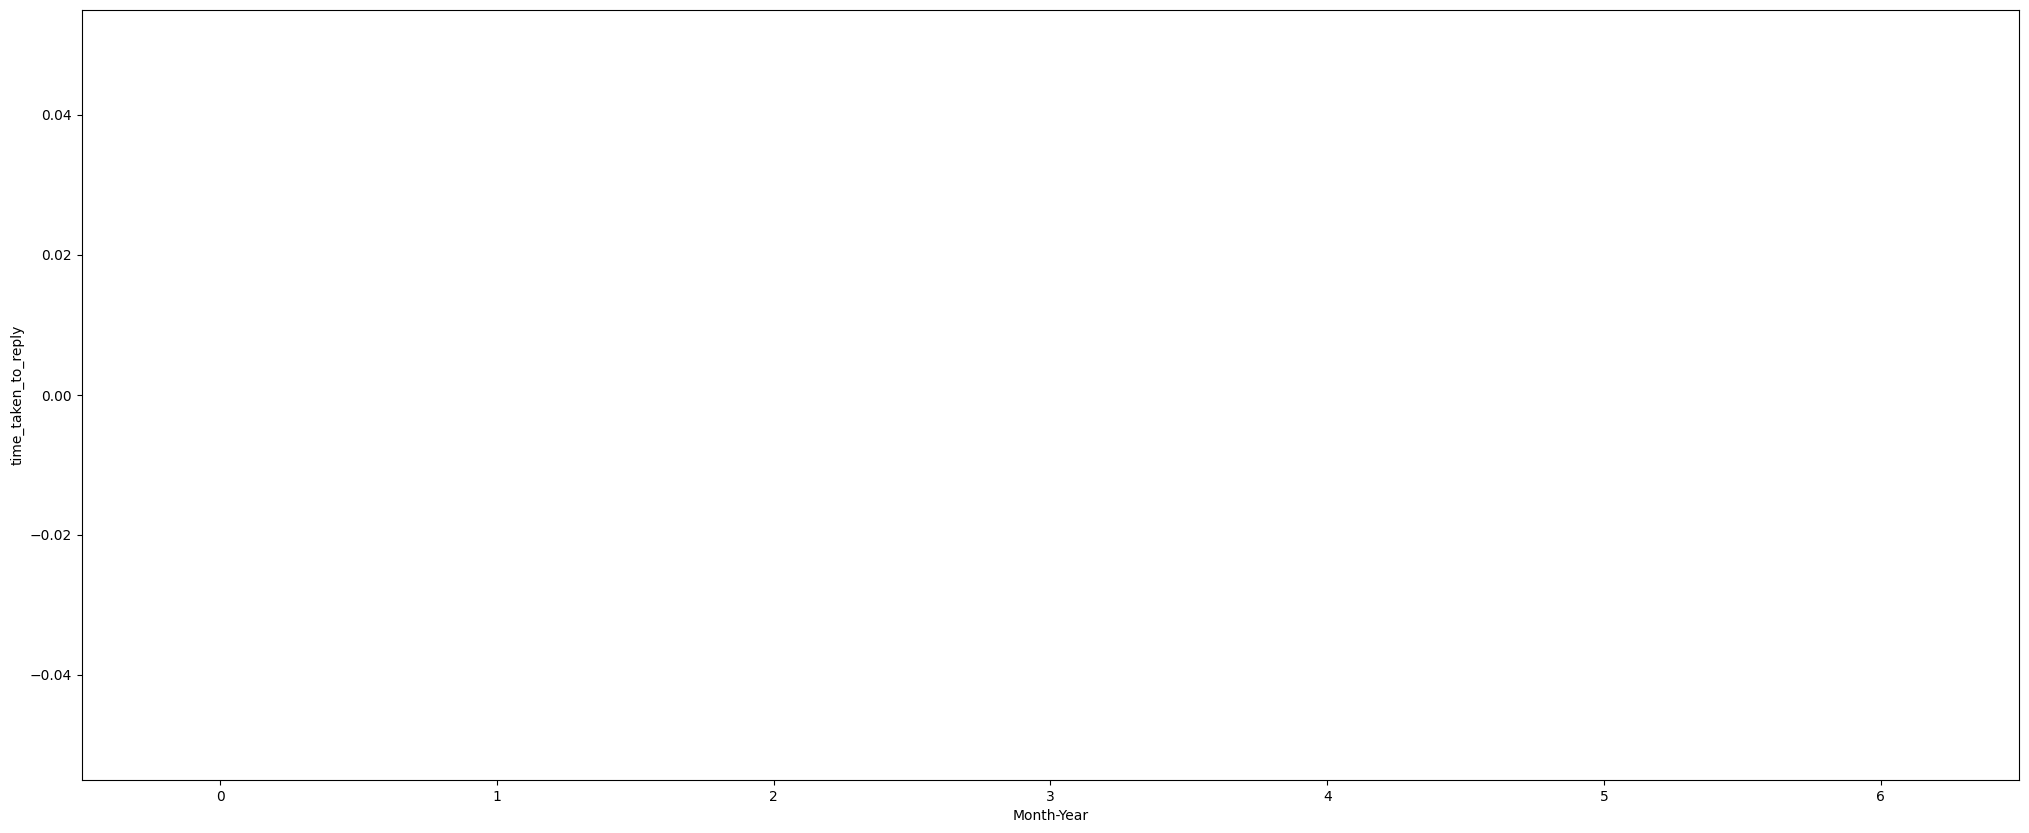

In [22]:
plt.figure(figsize=(25, 10))
ax = sns.barplot(data=replies_over_time, x="Month-Year", y="time_taken_to_reply")
for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=12, color='black', xytext=(0, 5), textcoords='offset points')


In [23]:
replied_low_ratings = replied[replied["stars"]<3]

In [24]:
replied_low_ratings[replied_low_ratings['review_datetime']>=one_year_ago].time_taken_to_reply.mean()

nan

In [25]:

replies_over_time_low_ratings = replied_low_ratings.groupby('Month-Year').agg({'time_taken_to_reply': 'mean'}).reset_index()
replies_over_time_low_ratings['time_taken_to_reply'] = replies_over_time_low_ratings['time_taken_to_reply'].round(1)

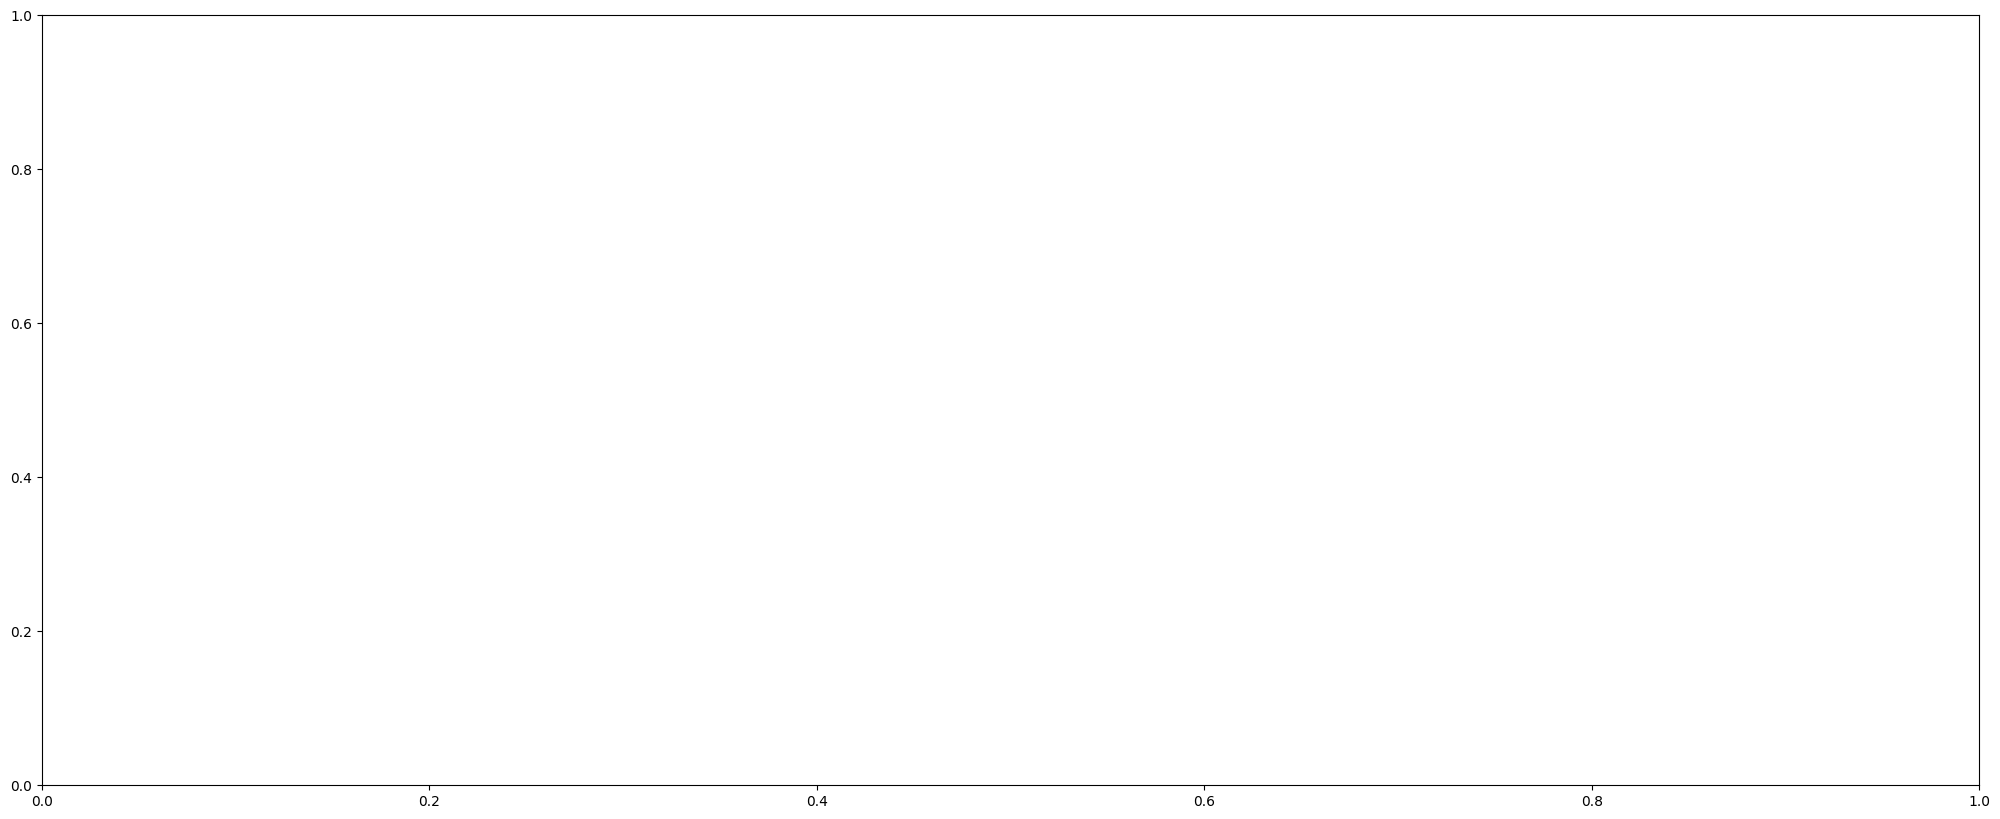

In [26]:
plt.figure(figsize=(25, 10))
ax = sns.barplot(data=replies_over_time_low_ratings, x="Month-Year", y="time_taken_to_reply")
for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=12, color='black', xytext=(0, 5), textcoords='offset points')


In [27]:
replies_over_time_low_ratings

,Month-Year,time_taken_to_reply


In [28]:
replied_high_ratings = replied[replied["stars"]>3]
replied_high_ratings[replied_high_ratings['review_datetime']>=one_year_ago].time_taken_to_reply.mean()

nan

In [29]:

replies_over_time_high_ratings = replied_high_ratings.groupby('Month-Year').agg({'time_taken_to_reply': 'mean'}).reset_index()
replies_over_time_high_ratings['time_taken_to_reply'] = replies_over_time_high_ratings['time_taken_to_reply'].round(1)

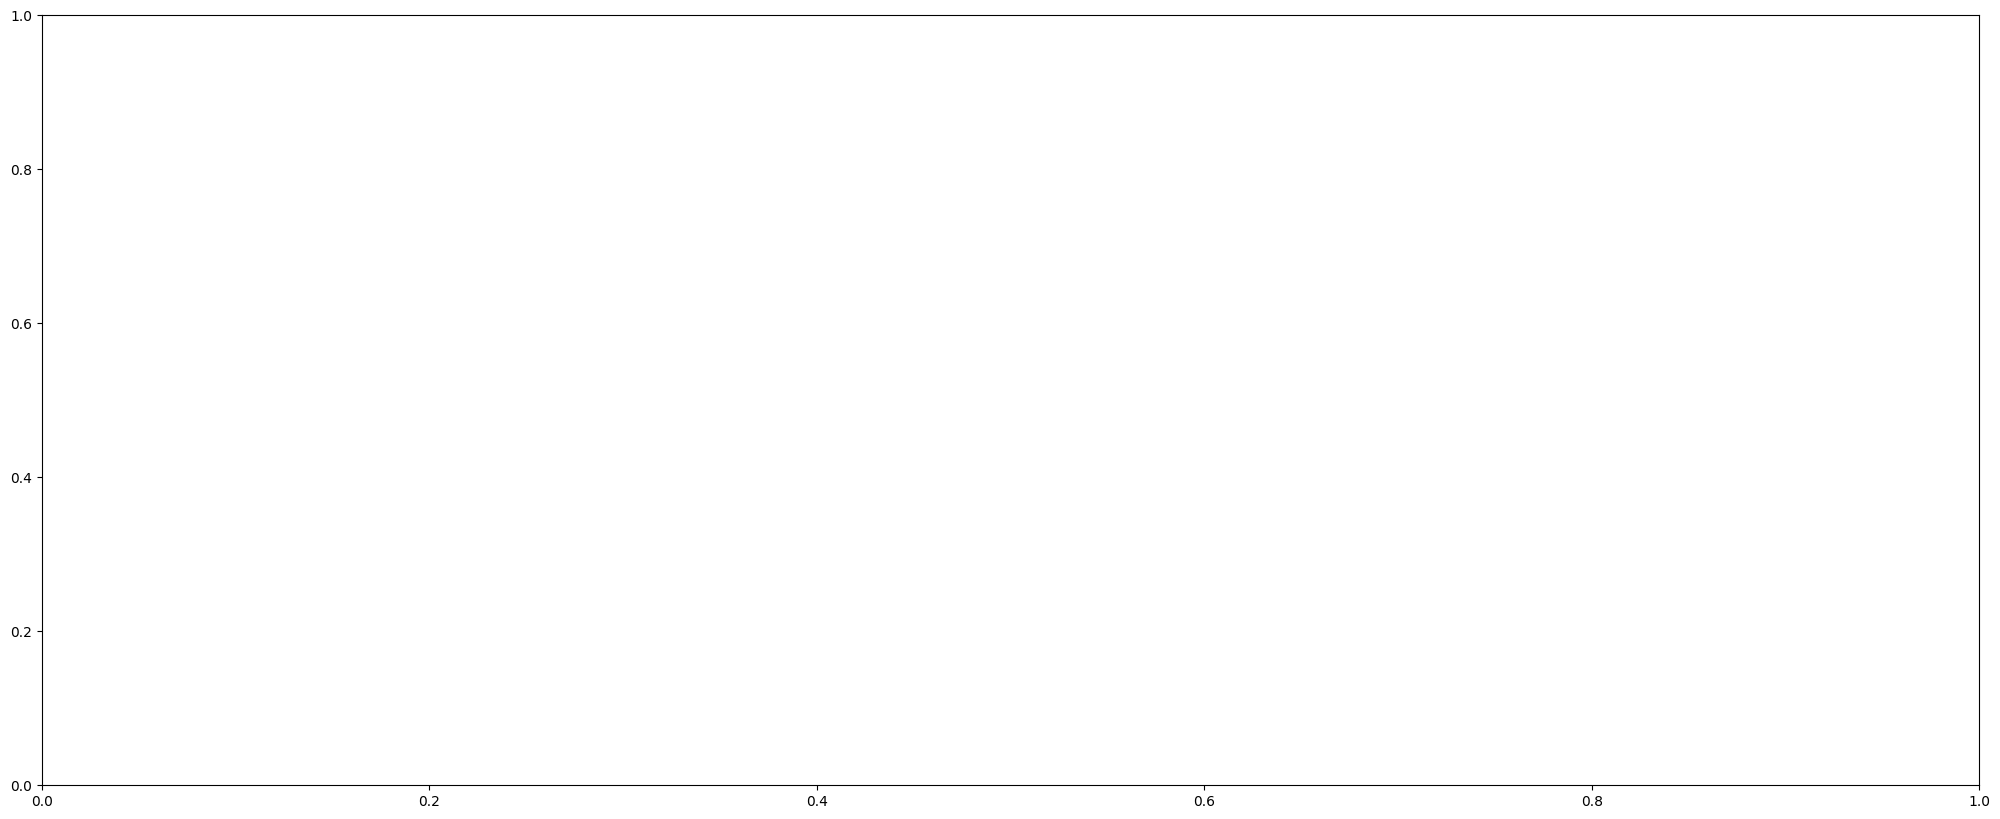

In [30]:
plt.figure(figsize=(25, 10))
ax = sns.barplot(data=replies_over_time_high_ratings, x="Month-Year", y="time_taken_to_reply")
for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=12, color='black', xytext=(0, 5), textcoords='offset points')


In [33]:
df[~df["CompanyReplyDate"].isna()]

,platform,id,stars,title,message,review_date,review_time,CompanyReply,CompanyReplyDate,CompanyReplyTime,review_datetime,company_reply_datetime,time_taken_to_reply,Month-Year
